<a href="https://colab.research.google.com/github/Itskindastrange/Text-Classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
#dropping NaN values from description and points bc we are goin to use those
df = df.dropna(subset=['description', 'points'])

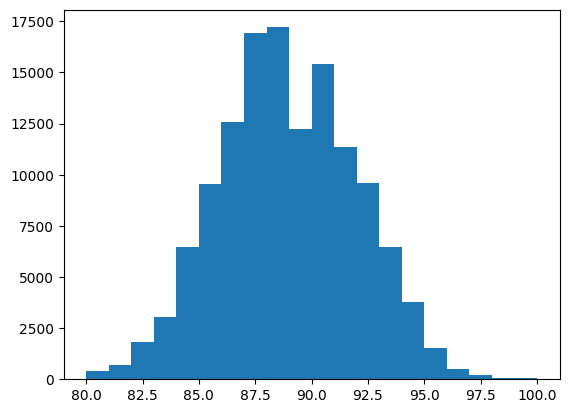

In [6]:
plt.hist(df.points,bins=20)
plt.show()

In [7]:
df['label'] = df.points.apply(lambda p: 1 if p >= 90 else 0)
df = df[['description', 'label']]

In [10]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [9]:
train,val,test=np.split(df.sample(frac=1),[int(.8*len(df)),int(.9*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
test_data = df_to_dataset(test)
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)

In [13]:
len(train_data),len(valid_data),len(test_data)

(102, 13, 13)

# Embedding

In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"


# Model

In [24]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [25]:
hub_layer = hub.KerasLayer(
    embedding,
    dtype=tf.string,
    trainable=True
    )

In [26]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.6784 - accuracy: 0.6219


[0.67844557762146, 0.621903121471405]

In [29]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 17ms/step - loss: 0.6782 - accuracy: 0.6235


[0.6781561970710754, 0.6235284805297852]

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    train_data,
    epochs=10,
    verbose=0,
    validation_data=valid_data,
    callbacks=[early_stopping, reduce_lr]
)



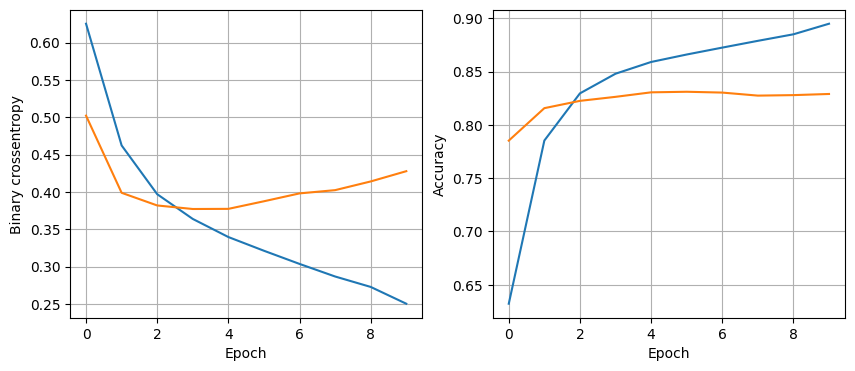

In [31]:
plot_history(history)

In [32]:
model.evaluate(test_data)

13/13 [==============================] - 10s 732ms/step - loss: 0.4206 - accuracy: 0.8321


[0.42062315344810486, 0.8321280479431152]

In [33]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
from google.colab import files

files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 16)                816       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191705 (183.84 MB)
Trainable params: 4

In [35]:
model.predict(test_data)

13/13 [==============================] - 3s 180ms/step


array([[0.97046643],
       [0.0027642 ],
       [0.00624439],
       ...,
       [0.97693455],
       [0.01308892],
       [0.0810919 ]], dtype=float32)

In [37]:
for i in model.predict(test_data):
  print(i)

Streaming output truncated to the last 5000 lines.
[0.03451047]
[0.01135959]
[9.773001e-06]
[0.14391486]
[0.8699378]
[0.7070057]
[0.7015398]
[8.385968e-08]
[0.00564877]
[0.00183849]
[0.00193058]
[0.00656126]
[0.06388176]
[0.9737682]
[0.00045287]
[0.9853902]
[0.88850504]
[0.9889261]
[0.884016]
[0.00999302]
[0.38500938]
[0.8488821]
[0.7236539]
[0.00012563]
[0.00048169]
[0.91232663]
[0.7420744]
[0.01987584]
[3.0102636e-05]
[0.9638673]
[0.06685109]
[0.01303051]
[0.43997622]
[0.9792609]
[0.00532321]
[0.09123942]
[0.2616295]
[0.00056959]
[0.35187706]
[6.15038e-05]
[0.02577306]
[0.9210706]
[0.0004521]
[0.9832668]
[0.0036991]
[0.97450584]
[0.9848941]
[0.9993524]
[0.24422733]
[0.02657147]
[0.14311248]
[0.749995]
[0.8712222]
[0.57038254]
[0.34641677]
[3.3286456e-06]
[0.35537344]
[0.9027297]
[0.05467649]
[0.02540253]
[0.00032901]
[0.00634864]
[0.07664507]
[0.7141513]
[0.23012526]
[0.00355016]
[0.00927916]
[0.13736066]
[0.95929885]
[0.01393618]
[9.1507e-05]
[0.1322655]
[0.00143961]
[0.00108527]
[0